# 공시지가 K-NN

In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import sklearn.neighbors as neg
import matplotlib.pyplot as plt
import folium
import json
import sklearn.preprocessing as pp

In [22]:
import warnings
warnings.filterwarnings('ignore')

**데이터 전처리**

In [23]:
# 이상치제거, 표준화 필요
all_data = pd.read_csv("data-set/house_clean02.csv", dtype=np.str, encoding='euc-kr') # encodig: 'euc-kr'

# 면적 당 공시지가 추가 # --> string type이므로 astype을 통해 타입 변경
all_data['y_price'] = all_data['공시지가'].astype(np.float32) / all_data['면적'].astype(np.float32)

# X: (x, y) / y: (면적 당 공시지가) #
X = all_data.iloc[:, 9:11].astype(np.float32) # shape (28046, 2)
y = all_data['y_price'] # shape (28046, )

## Robust scaling ## --> 이상치를 반영한 정규화(min-max)
rs = pp.RobustScaler()
y_scale = rs.fit_transform(np.array(y).reshape(-1, 1))

In [24]:
## 실거래가 아파트 데이터 전처리 ## --> shape (281684, 7)
all_data_apt = pd.read_csv("data-set/total_Apt.csv", sep=",", encoding='euc-kr')
all_data_apt['price_big'] = all_data_apt['Price'] / all_data_apt['Howbig']
X_apt = all_data_apt.iloc[:, -3:-1] # shape (281684, 2)
y_apt_scale = rs.fit_transform(np.array(all_data_apt['price_big']).reshape(-1, 1)) # shape(281684, 1)

## 실거래가 연립 데이터 전처리 ## --> shape ()
all_data_town = pd.read_csv("data-set/total_Townhouse01.csv", sep=",", encoding="cp949")
all_data_town['price_big'] = all_data_town['Price'] / all_data_town['Howbig']
X_town = all_data_town.iloc[:, -3:-1] # shape (281684, 2)
y_town_scale = rs.fit_transform(np.array(all_data_town['price_big']).reshape(-1, 1)) # shape(281684, 1)

## 어린이집 데이터 전처리 ##
all_center = json.load(open("data-set/allmap.json", encoding='utf-8'))
c_header = all_center['DESCRIPTION'] # JSON 분리
c_data = all_center['DATA']
c_alldf = pd.DataFrame(c_data)

# 특정 열만 선택 #
c_alldf = c_alldf[['cot_conts_name', 'cot_coord_x', 'cot_coord_y', 'cot_value_01', 'cot_gu_name']]
c_alldf.columns = ['name', 'x', 'y', 'kinds', 'location']
x_test = c_alldf[c_alldf['kinds'] == "국공립"] # 국공립만 선택


In [25]:
## KNN regressor##
k_list = [i for i in range(15,26, 2)]

# minkowski --> p = 2  // 평균 회귀 --> regressor #
knn_fit = neg.KNeighborsRegressor(n_neighbors=k_list[0], p=2, metric='minkowski')
knn_fit.fit(X, y_scale)
knn_fit.fit(X_apt, y_apt_scale)

## predict --> 평균가 적용 ##
pred = knn_fit.predict(x_test.iloc[:, 1:3])
x_test['소득추정'] = pred
for i in range(len(x_test['location'])):
    x_test['location'].values[i] = x_test['location'].values[i][:-1] # '구' 빼기

## groupby를 통해 구별 평균 소득 추정 ##
mean = x_test.groupby(['location'], as_index=False).mean()

**데이터 시각화**

In [26]:
# 한글 폰트 깨지는 문제 #
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

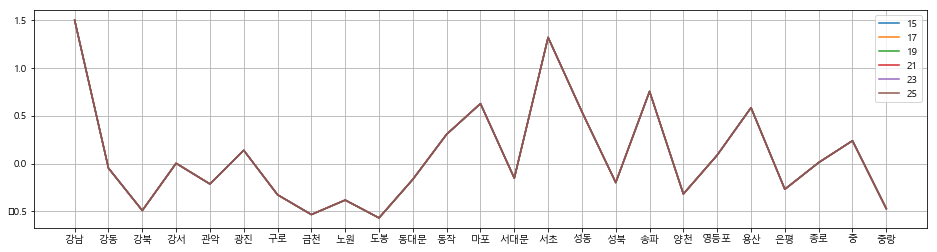

In [29]:
## k마다 평균추정치 비교 ##  main 코드 --> 구별 평균치 추정
# 공시지가 & 아파트 실거래가 & 연립주택 실거래가에 따라 순위가 바뀜 #
plt.figure()
sortList = []
for i in range(len(k_list)):
    knn_fit = neg.KNeighborsRegressor(n_neighbors=k_list[i], p=2, metric='minkowski')
    knn_fit.fit(X, y_scale)
    knn_fit.fit(X_apt, y_apt_scale)
#     knn_fit.fit(X_town, y_town_scale)
    x_test["predK%i" %k_list[i]] = knn_fit.predict(x_test.iloc[:, 1:3])
    mean = x_test.groupby(['location'], as_index=False).mean()
    price_pred = pd.DataFrame(mean.iloc[:, -1])
    price_pred.index = mean['location']
    sortList.append(price_pred)
    plt.plot(price_pred)
plt.legend(k_list)
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

In [28]:
## 구별 sort ##
for sort in sortList:
     print(sort.sort_values(by=[sort.columns[0]], axis=0), end="\n=====================\n")

           predK15
location          
도봉       -0.575006
금천       -0.539952
강북       -0.510802
중랑       -0.503658
노원       -0.386899
양천       -0.352516
구로       -0.344426
은평       -0.270505
성북       -0.213862
관악       -0.212240
서대문      -0.197440
동대문      -0.171543
강동       -0.073153
종로       -0.032459
강서       -0.013605
영등포       0.054447
광진        0.124560
중         0.198588
동작        0.271331
성동        0.553028
용산        0.558709
마포        0.637919
송파        0.736348
서초        1.260617
강남        1.479104
           predK17
location          
도봉       -0.572341
금천       -0.535012
강북       -0.503927
중랑       -0.496314
노원       -0.386297
양천       -0.346060
구로       -0.344143
은평       -0.271974
관악       -0.214465
성북       -0.209386
서대문      -0.182091
동대문      -0.177273
강동       -0.068214
종로       -0.023795
강서       -0.011049
영등포       0.065142
광진        0.131971
중         0.199624
동작        0.283667
성동        0.555092
용산        0.568061
마포        0.638608
송파        0.742678
서초        1.